In [1]:
import warnings
warnings.filterwarnings('ignore')
import pyterrier as pt

if not pt.started():
    pt.init()

import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', False)

import pyt_splade
splade = pyt_splade.Splade()

dataset_name = 'msmarco-passage'
eval_ds_name = 'dev'
dataset = pt.get_dataset(f'irds:{dataset_name}')
eval_dataset = pt.get_dataset(f'irds:{dataset_name}/{eval_ds_name}')
topics = eval_dataset.get_topics()
qrels = eval_dataset.get_qrels()

Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.10 (build: craigm 2024-08-22 17:33), helper_version=0.0.8]
/tmp/ipykernel_66997/163800797.py:6: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


In [2]:
dataset_df = pd.DataFrame(dataset.get_corpus_iter(verbose=True))

msmarco-passage documents: 100%|██████████| 8841823/8841823 [01:32<00:00, 95101.59it/s] 


In [4]:
import numpy as np
dataset_df['rtr_score'] = np.zeros(dataset_df.shape[0])

In [5]:
dataset_df['docid'] = dataset_df['docno'].astype(int)

In [6]:
dataset_df.dtypes

text         object 
docno        object 
rtr_score    float64
docid        int64  
dtype: object

In [7]:
#################### bm25 ###########################

In [8]:
bm25 = pd.read_csv('/nfs/primary/retrievability-bias/results_bm25.csv')

In [9]:
bm25 = bm25.groupby(['docid'])['docid'].count()
bm25 = bm25.to_frame('rtr_cnt').reset_index()
bm25 = bm25.sort_values(by='rtr_cnt')
total = bm25['rtr_cnt'].sum()

In [10]:
bm25.columns.to_list()

['docid', 'rtr_cnt']

In [11]:
bm25.head(10)

,docid,rtr_cnt
401666,5427959,1
514424,6934980,1
514425,6934982,1
514426,6934984,1
514427,6934985,1
514428,6934987,1
514429,6934988,1
514430,6934991,1
514431,6935015,1
514423,6934978,1


In [12]:
# bm25.index.name = 'no'
# bm25 = bm25.rename(columns = {'docid':'count'})

In [13]:
bm25['rtr_score'] = bm25['rtr_cnt']/total # normalisation

In [14]:
bm25.tail(10)

,docid,rtr_cnt,rtr_score
543262,7137907,213,0.000211
230962,3058085,325,0.000321
88159,1149020,358,0.000354
515529,6949099,372,0.000368
543416,7138532,501,0.000496
35579,462225,613,0.000606
113041,1474877,820,0.000811
12804,169073,874,0.000865
151878,1985345,1119,0.001107
516221,6958226,1294,0.001280


In [15]:
def set_score(df,row):
    docid = row['docid'] # int.64 to str
    rtr_score = row['rtr_score']
    # print(row.name)
    df.loc[docid,'rtr_score'] = rtr_score

In [16]:
dataset_bm25 = dataset_df.copy()
for _, row in bm25.iterrows():
    set_score(dataset_bm25, row)

In [17]:
dataset_bm25[dataset_bm25['rtr_score'] > 0].head(10)

,text,docno,rtr_score,docid
2,Essay on The Manhattan Project - The Manhattan Project The Manhattan Project was to see if making an atomic bomb possible. The success of this project would forever change the world forever making it known that something this powerful can be manmade.,2,1.978402e-06,2
4,"versions of each volume as well as complementary websites. The first website–The Manhattan Project: An Interactive History–is available on the Office of History and Heritage Resources website, http://www.cfo. doe.gov/me70/history. The Office of History and Heritage Resources and the National Nuclear Security",4,9.892009e-07,4
63,"Hepatitis B and C, alcoholism, hemochromatosis, and primary biliary cirrhosis -- all causes of cirrhosis -- are some of the major risk factors for liver cancer. Cirrhosis due to hepatitis C is the leading cause of hepatocellular carcinoma in the United States.rimary Biliary Cirrhosis. Up to 95% of primary biliary cirrhosis (PBC) cases occur in women, usually around age 50. In people with PBC, the immune system attacks and destroys cells in the liver’s bile ducts. Like many autoimmune disorders, the causes of PBC are unknown.",63,9.892009e-07,63
68,"Primary Biliary Cirrhosis. Up to 95% of primary biliary cirrhosis (PBC) cases occur in women, usually around age 50. In people with PBC, the immune system attacks and destroys cells in the liver’s bile ducts. Like many autoimmune disorders, the causes of PBC are unknown.rimary Biliary Cirrhosis. Up to 95% of primary biliary cirrhosis (PBC) cases occur in women, usually around age 50. In people with PBC, the immune system attacks and destroys cells in the liver’s bile ducts. Like many autoimmune disorders, the causes of PBC are unknown.",68,1.978402e-06,68
73,"The grape harvest was usually completed before Tabernacles, but most of the olive harvest came after the autumn festivals. In ancient Israel the primary harvest season extended from April to November. This harvest period might be subdivided into three seasons and three major crops: the spring grain harvest, the summer grape harvest and the autumn olive harvest.",73,9.892009e-07,73
78,"Pentecost, near the end of the grain harvest, included grain and loaf offerings (verses 16-17). Pentecost was also called “the Feast of Harvest” (Exodus 23:16). Barley and wheat were planted in the autumn and ripened in spring. Barley matured faster and would be harvested sooner. The firstfruits of grain offered during the Festival of Unleavened Bread would have been barley.",78,9.892009e-07,78
81,What organs are on your left side of body. Causes of Pain under Left Rib Cage. Here are just some of the possible reasons why you may be feeling pain under your left rib cage: Gas Stuck in the Colon – There is a chance that you have gas stuck in your colon. The amount of gas that is stuck may be excessive.,81,9.892009e-07,81
89,"1 COMMERCIAL CONCRETE. Since 1981, Wheeler Services, Inc has handled commercial concrete projects such as Medical offices, Auto plants, Commercial buildings, Retail buildings, Colleges, Manufacturing Plants, Restaurants, Churches, Our areas of service include Georgia, Alabama, North Carolina and South Carolina.",89,9.892009e-07,89
90,"Lendmark Financial Services, LLC Steve was named Chief Credit Officer of Lendmark Financial Services, LLC in January 2016. In his current role, Steve oversees the credit philosophy and manages both the short and long-term credit strategy for Lendmark.",90,9.892009e-07,90
121,"Condo Old Montreal - Compare all new condominiums for sale in Old Montreal, Island of Montreal. Vieux-Montral, Montral, QC, Canada.",121,9.892009e-07,121


In [18]:
####################### bm25 >> monot5 ###############################

In [19]:
monot5 = pd.read_csv('/nfs/primary/retrievability-bias/results_bm25_monot5_r100.csv',) # 100 docs retrieved for each query.

In [75]:
monot5.shape

(4351500, 3)

In [21]:
monot5 = monot5.sort_values(by=['docid','rank'], ascending=[True, True])

In [22]:
monot5 = monot5.groupby(['docid']).head(10)

In [23]:
monot5.shape

(9216924, 8)

In [24]:
monot5 = monot5.groupby(['docid'])['docid'].count()
monot5 = monot5.to_frame('rtr_cnt').reset_index()
monot5 = monot5.sort_values(by='rtr_cnt')
total = monot5['rtr_cnt'].sum()
monot5['rtr_score'] = monot5['rtr_cnt']/total # normalisation


In [25]:
dataset_monot5 = dataset_df.copy()
for _, row in monot5.iterrows():
    set_score(dataset_monot5, row)

In [26]:
dataset_monot5[dataset_monot5['rtr_score'] > 0].shape

(4351500, 4)

In [27]:
################ splade  ##################################

In [28]:
splade = pd.read_csv('/nfs/primary/retrievability-bias/results_splade.csv',) # 100 docs retrieved for each query.

In [29]:
splade.columns.to_list()

['Unnamed: 0',
 'qid',
 'docid',
 'docno',
 'rank',
 'score',
 'query',
 'query_toks',
 'text']

In [30]:
splade = splade.groupby(['docid'])['docid'].count()
splade = splade.to_frame('rtr_cnt').reset_index()
splade = splade.sort_values(by='rtr_cnt')
total = splade['rtr_cnt'].sum()
splade['rtr_score'] = splade['rtr_cnt']/total # normalisation

In [31]:
splade.shape

(617193, 3)

In [33]:
dataset_splade = dataset_df.copy()
for _, row in splade.iterrows():
    set_score(dataset_splade, row)

In [34]:
dataset_splade[dataset_splade['rtr_score'] > 0].shape

(617193, 4)

In [35]:
dataset_bm25 = dataset_bm25.sort_values(by='rtr_score',ascending=False)
dataset_bm25.to_csv('/nfs/datasets/cxj/retrievability-bias/dataset_bm25.csv')

In [36]:
dataset_monot5 = dataset_monot5.sort_values(by='rtr_score',ascending=False)
dataset_monot5.to_csv('/nfs/datasets/cxj/retrievability-bias/dataset_monot5.csv')

In [37]:
dataset_splade = dataset_splade.sort_values(by='rtr_score',ascending=False)
dataset_splade.to_csv('/nfs/datasets/cxj/retrievability-bias/dataset_splade.csv')

In [158]:
num_docs = max(bm25.shape[0],monot5.shape[0],splade.shape[0])
split = 15
intv = int(num_docs/split)

In [159]:
intv

290100

In [160]:
bm25_scores = []
for i in range(0,num_docs,intv):
    bm25_scores.append(dataset_bm25[i:i+intv]['rtr_score'].sum())

bm25_scores.append(0.0) # the retrievability scores of the reset of corpus docs are 0

In [161]:
bm25_scores

[0.4923094576508257,
 0.2869671793035431,
 0.22072336304563078,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [162]:
monot5_scores = []
for i in range(0,num_docs,intv):
    monot5_scores.append(dataset_monot5[i:i+intv]['rtr_score'].sum())

monot5_scores.append(0.0) # the retrievability scores of the reset of corpus docs are 0

In [163]:
len(monot5_scores)

16

In [164]:
splade_scores = []
for i in range(0,num_docs,intv):
    splade_scores.append(dataset_splade[i:i+intv]['rtr_score'].sum())

splade_scores.append(0.0) # the retrievability scores of the reset of corpus docs are 0

In [165]:
len(splade_scores)

16

In [166]:
scale_num = max(len(bm25_scores),len(monot5_scores),len(splade_scores))
scale_num

16

In [167]:
import numpy as np
import matplotlib.pyplot as plt

x_ticks = np.arange(1,scale_num +1)
x_ticks

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

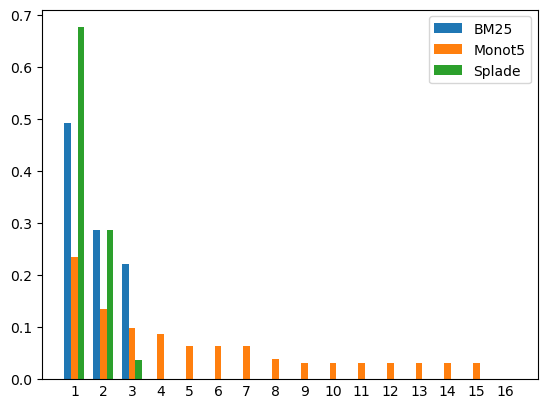

In [168]:

# a = np.random.random(intv)
# b = np.random.random(intv)
# c = np.random.random(intv)

total_width, n = 0.7, 3
width = total_width / n
x = x_ticks
x = x - (total_width - width) / 2

plt.bar(x, bm25_scores,  width=width, label='BM25')
plt.bar(x + width, monot5_scores, width=width, label='Monot5')
plt.bar(x + 2 * width, splade_scores, width=width, label='Splade')

plt.tick_params(axis='x',length=0)
plt.xticks(ticks=x_ticks, labels=None)
plt.legend()
plt.show()

In [125]:
x

array([ 0.9,  1.9,  2.9,  3.9,  4.9,  5.9,  6.9,  7.9,  8.9,  9.9, 10.9])